In [ ]:
#1
import torch
import torchvision

from torch.utils.data import Dataset, DataLoader
from torch import nn
from PIL import Image,ImageChops
from torchvision import transforms

#from torch_lr_finder import LRFinder
from tqdm.notebook import tqdm_notebook


In [ ]:
#2
class ConvBnAct(nn.Module):
    """Layer grouping a convolution, batchnorm, and activation function"""
    def __init__(self, n_in, n_out, kernel_size=3, stride=1, padding=0, groups=1, bias=False, bn=True, act=True):
        super().__init__()
        
        self.conv = nn.Conv2d(n_in, n_out, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=bias)
        self.bn   = nn.BatchNorm2d(n_out) if bn else nn.Identity()
        self.act  = nn.SiLU() if act else nn.Identity()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

class SEBlock(nn.Module):
    """Squeeze-and-excitation block"""
    def __init__(self, n_in, r=24):
        super().__init__()

        N = n_in if (n_in//r == 0) else n_in//r 

        self.squeeze    = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(nn.Conv2d(n_in, N, kernel_size=1),
                                        nn.SiLU(),
                                        nn.Conv2d(N, n_in, kernel_size=1),
                                        nn.Sigmoid())
    
    def forward(self, x):
        y = self.squeeze(x)
        y = self.excitation(y)
        return x * y

class DropSample(nn.Module):
    """Drops each sample in x with probability p during training"""
    def __init__(self, p=0):
        super().__init__()

        self.p = p
    
    def forward(self, x):
        if (not self.p) or (not self.training): return x
        
        batch_size = len(x)
        random_tensor = torch.cuda.FloatTensor(batch_size, 1, 1, 1).uniform_()
        bit_mask = self.p<random_tensor

        x = x.div(1-self.p)
        x = x * bit_mask
        return x

class MBConvN(nn.Module):
    """MBConv with an expansion factor of N, plus squeeze-and-excitation"""
    def __init__(self, n_in, n_out, expansion_factor, kernel_size=3, stride=1, r=24, p=0):
        super().__init__()

        padding = (kernel_size-1)//2
        expanded = expansion_factor*n_in
        self.skip_connection = (n_in == n_out) and (stride == 1)

        self.expand_pw  = nn.Identity() if (expansion_factor == 1) else ConvBnAct(n_in, expanded, kernel_size=1)
        self.depthwise  = ConvBnAct(expanded, expanded, kernel_size=kernel_size, stride=stride, padding=padding, groups=expanded)
        self.se         = SEBlock(expanded, r=r)
        self.reduce_pw  = ConvBnAct(expanded, n_out, kernel_size=1, act=False)
        self.dropsample = DropSample(p)
    
    def forward(self, x):
        residual = x

        x = self.expand_pw(x)
        x = self.depthwise(x)
        x = self.se(x)
        x = self.reduce_pw(x)

        if self.skip_connection:
            x = self.dropsample(x)
            x = x + residual

        return x

In [ ]:
#3
p = 0
class GenericNN(nn.Module):
    """Generic EfficientNet that takes in the width and depth scale factors and scales accordingly"""
    def __init__(self):
      super().__init__()

      self.stem  = ConvBnAct(1, 32, stride=2, padding=1)

      self.stages = nn.Sequential( MBConvN(32, 16, 1,3,2,24,0)
                                  ,MBConvN(16, 16, 4,3,2,24,0)
                                  ,MBConvN(16, 16, 4,3,1,24,0)

                                  ,MBConvN(16, 24, 4,3,2,24,p*0.05)
                                  ,MBConvN(24, 24, 4,3,1,24,p*0.05)
                                  
                                  ,MBConvN(24, 40, 4,3,2,24,p*0.015)
                                  ,MBConvN(40, 40, 4,3,1,24,p*0.015)

                                  ,MBConvN(40, 80, 4,3,1,24,p*0.025)
                                  ,MBConvN(80, 80, 4,3,1,24,p*0.025)

                                  ,MBConvN(80, 112, 4,3,2,24,p*0.035)
                                  ,MBConvN(112,112, 4,3,1,24,p*0.035)

                                  ,MBConvN(112, 192, 4,3,2,24,p*0.045)
                                  ,MBConvN(192, 192, 4,3,1,24,p*0.045)
                                )

      self.head = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                               nn.Flatten(),
                               nn.Linear(192,2)
                               )


    def forward(self, x):
      x = self.stem(x)
      x = self.stages(x)
      x = self.head(x)
      return x

In [ ]:
#4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CFG:
    Check_Point_Rate = 1
    img_size         = 800
    batch_size       = 20#10#6#40 #para VGG
    epoch            = 50
    address          = "./110mm 5.10.2021"

In [ ]:
#5
train_tfms = transforms.Compose([
                                  transforms.Grayscale()
                                 ,transforms.ToTensor()
                                 
                                 ,transforms.Lambda(lambda x: x.masked_fill_((x > 0.5),0))
                                 ,transforms.Lambda(lambda x: transforms.functional.autocontrast(x))  
                                 #,transforms.Lambda(lambda x: ImageChops.invert(x))                                 
                                 #,transforms.RandomAffine(degrees=(-180,180),fill=255,translate=(0.01,0.01))#,scale=(.99,1.01))
                                 ,transforms.Resize((CFG.img_size, CFG.img_size))
                                 ,transforms.RandomHorizontalFlip(p=0.5)
                                 ,transforms.RandomVerticalFlip(p=0.5)
                                 #,transforms.Lambda(lambda x: x.masked_fill_((x < 0.5),0))    
                                 #,transforms.Lambda(lambda x: sobel(x))
                                 #,transforms.Lambda(lambda x: x.masked_fill_((x > 0.5),1))
                                 #,transforms.Lambda(lambda x: transforms.functional.autocontrast(x)) 
                                 #,transforms.Normalize((0.226), (0.694))
                                 ])

valid_tfms = transforms.Compose([
                                  transforms.Grayscale()
                                 ,transforms.ToTensor()
    
                                 #,transforms.RandomAffine(degrees=(-180,180),fill=255,translate=(0.01,0.01))#,scale=(.99,1.01))
                                 ,transforms.Lambda(lambda x: x.masked_fill_((x > 0.5),0))
                                 ,transforms.Lambda(lambda x: transforms.functional.autocontrast(x))                             
                                 ,transforms.Resize((CFG.img_size, CFG.img_size))
                                 ])

trainDataset = torchvision.datasets.ImageFolder(CFG.address + "/Train/",transform=train_tfms)
validDataset = torchvision.datasets.ImageFolder(CFG.address + "/Test/",transform=valid_tfms)
testDataset  = torchvision.datasets.ImageFolder("./110mm 1.11.2021" + "/Test/",transform=valid_tfms)

print(len(trainDataset), len(validDataset), len(testDataset))

trainDataLoader = DataLoader(dataset=trainDataset, batch_size=CFG.batch_size, shuffle=True)
validDataLoader = DataLoader(dataset=validDataset, batch_size=CFG.batch_size)
testDataLoader  = DataLoader(dataset=testDataset , batch_size=CFG.batch_size)

print(len(trainDataLoader), len(validDataLoader), len(testDataLoader))


3368 1123 437
169 57 22


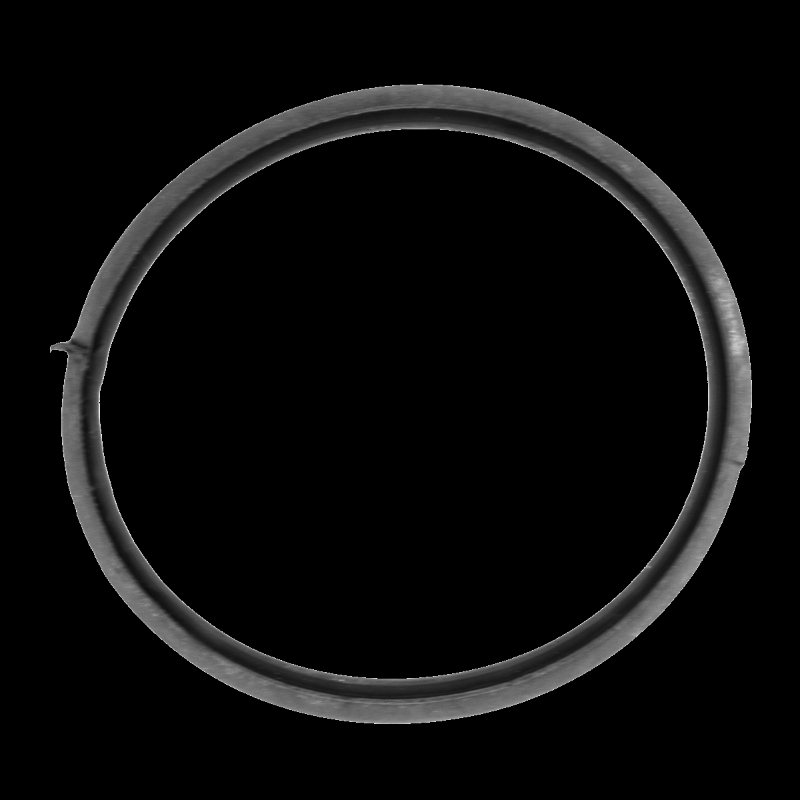

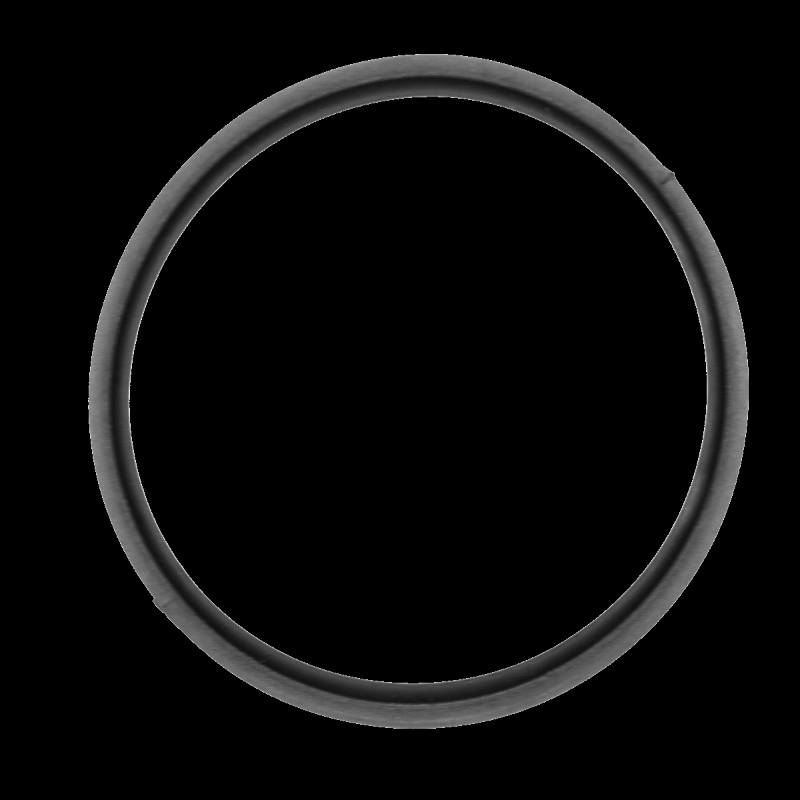

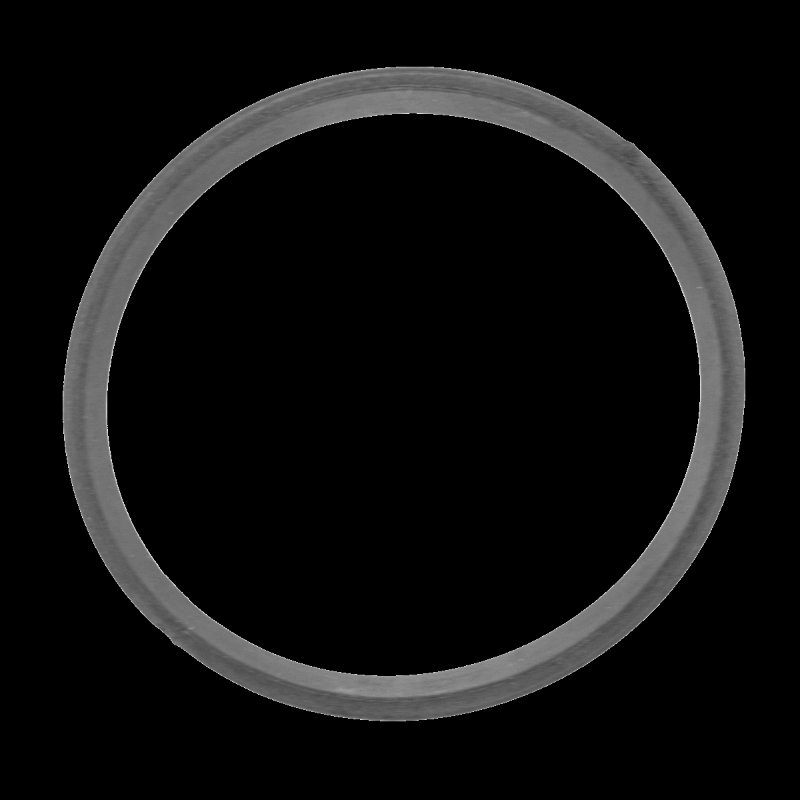

(None, None, None)

In [ ]:
#6
tensorToImage = torchvision.transforms.ToPILImage()
imageToTensor = torchvision.transforms.ToTensor()
img_train, A = trainDataset[33]
img_valid, B = validDataset[50]
img_test , C = testDataset[5]
tensorToImage(img_train).show(),tensorToImage(img_valid).show(),tensorToImage(img_test).show()

In [ ]:
#7
def Test(DataLoader):
    model.eval() 
    total     = 0
    loss      = 0
    accuracy  = 0

    with torch.no_grad():
        t =  tqdm_notebook(DataLoader)
        for (inputs, labels) in t:
            inputs, labels = inputs.to(device),labels.to(device)
                         
            logps      = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            loss      += batch_loss.item()
            accuracy  += (torch.argmax(logps,1) == labels).sum().item()
            total     += labels.size()[0]

            t.set_postfix_str("Test: %f" % batch_loss)
           
    return  accuracy/total, loss/total

In [ ]:
#8
def Train(DataLoader, Optimizer):    
        model.train()        
        loss  = 0
        total = 0
        
        t =  tqdm_notebook(DataLoader)
        for (inputs, labels) in t:
            inputs, labels = inputs.to(device),labels.to(device)

            logps      = model.forward(inputs)
            batch_loss = criterion(logps, labels)
           
            Optimizer.zero_grad();
            batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            Optimizer.step()
            scheduler.step()
            
            loss  += batch_loss.item()
            total += labels.size()[0]
            
            t.set_postfix_str("Train: %f" % batch_loss)
        
        return (loss/total)

In [ ]:
#9
def Fit():
      valid_min_loss =  general_loss#float('inf')
      print("Initial loss: ",valid_min_loss)
      for idx in range(1,CFG.epoch):
            print("Epoch: {}, Learning Rate: {}".format(idx,scheduler.get_last_lr())) 
            Train(trainDataLoader, optimizer)
                        
            if (idx % CFG.Check_Point_Rate == 0):
                acc, loss = Test(trainDataLoader)
                accT, lossT = Test(validDataLoader)
                print("TRAIN ACURACCY: {:.6f}, TRAIN LOSS: {:.6f}".format(acc, loss))
                print("TEST ACURACCY : {:.6f}, TEST LOSS : {:.6f}".format(accT, lossT))
                    
                if lossT <= valid_min_loss :
                    print("Valid_loss decreased {} ----------> {}".format(valid_min_loss,lossT))
                    torch.save({
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': lossT,
                            'acc':accT
                            }, "./best_model.pth")
                    
                    valid_min_loss = lossT 

      checkpoint = torch.load("./best_model.pth")
      model.load_state_dict(checkpoint['model_state_dict'])

      print("BEST: TEST ACURACCY: {:.6f}, TEST LOSS: {:.6f}".format(checkpoint['acc'],checkpoint['loss']))
      torch.save({
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': checkpoint['loss'],
          'acc':checkpoint['acc']
      }, "./best_model " + str(checkpoint['acc']) + ".pth")

In [ ]:
#10
#Entrenando NN desde Cero

criterion = torch.nn.CrossEntropyLoss()
model = GenericNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1E-4, weight_decay=0.08)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1E-5, max_lr=1E-4, cycle_momentum=False)

CFG.Check_Point_Rate = 1
CFG.epoch = 100

general_loss = float("inf")
Fit()

Initial loss:  inf
Epoch: 1, Learning Rate: [1e-05]


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

TRAIN ACURACCY: 0.524347, TRAIN LOSS: 0.034711
TEST ACURACCY : 0.494212, TEST LOSS : 0.035422
Valid_loss decreased inf ----------> 0.0354216519680176
Epoch: 2, Learning Rate: [1.7604999999999985e-05]


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

TRAIN ACURACCY: 0.533254, TRAIN LOSS: 0.034566
TEST ACURACCY : 0.495102, TEST LOSS : 0.035357
Valid_loss decreased 0.0354216519680176 ----------> 0.03535654809150118
Epoch: 3, Learning Rate: [2.5210000000000004e-05]


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

TRAIN ACURACCY: 0.550772, TRAIN LOSS: 0.034446
TEST ACURACCY : 0.484417, TEST LOSS : 0.035586
Epoch: 4, Learning Rate: [3.281499999999999e-05]


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

TRAIN ACURACCY: 0.512470, TRAIN LOSS: 0.034900
TEST ACURACCY : 0.484417, TEST LOSS : 0.036136
Epoch: 5, Learning Rate: [4.042000000000001e-05]


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

TRAIN ACURACCY: 0.546021, TRAIN LOSS: 0.034835
TEST ACURACCY : 0.504898, TEST LOSS : 0.037262
Epoch: 6, Learning Rate: [4.802499999999999e-05]


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

TRAIN ACURACCY: 0.561461, TRAIN LOSS: 0.033477
TEST ACURACCY : 0.517364, TEST LOSS : 0.035824
Epoch: 7, Learning Rate: [5.5630000000000015e-05]


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

TRAIN ACURACCY: 0.671021, TRAIN LOSS: 0.030780
TEST ACURACCY : 0.560997, TEST LOSS : 0.034138
Valid_loss decreased 0.03535654809150118 ----------> 0.03413845233798345
Epoch: 8, Learning Rate: [6.3235e-05]


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

TRAIN ACURACCY: 0.682898, TRAIN LOSS: 0.029868
TEST ACURACCY : 0.600178, TEST LOSS : 0.033249
Valid_loss decreased 0.03413845233798345 ----------> 0.0332493590438143
Epoch: 9, Learning Rate: [7.084000000000002e-05]


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

In [ ]:
#continuar entrenamiento con modelo que YA esta cargado en memoria.

optimizer = torch.optim.Adam(model.parameters(), lr=1E-5, weight_decay=0.03)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1E-6, max_lr=4E-5, cycle_momentum=False)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=1)
CFG.Check_Point_Rate = 1
CFG.epoch = 50

general_loss = 0.04
Fit()

In [ ]:
#Cargando desde archivo para continuar entrenamiento.
model = GenericNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1E-5, weight_decay=0.0)
criterion = torch.nn.CrossEntropyLoss()

checkpoint = torch.load("./best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

for g in optimizer.param_groups:
    print( g['lr'])
    print(g['weight_decay'])
    g['weight_decay'] = 0.0
    g['lr'] = 1e-04
    general_loss =checkpoint['loss']

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1E-6, max_lr=4E-5, cycle_momentum=False)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=1)
CFG.Check_Point_Rate = 1
CFG.epoch = 100

Fit()

1.3825e-05
0.0
Initial loss:  0.01809017247423357
Epoch: 1, Learning Rate: [1e-05]


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

TRAIN ACURACCY: 0.540974, TRAIN LOSS: 0.017465
TEST ACURACCY : 0.496883, TEST LOSS : 0.018218
Epoch: 2, Learning Rate: [2.6574999999999995e-06]


  0%|          | 0/85 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
!pip install torchsummary
from torchsummary import summary

image_size = 400

summary(model, (1, image_size, image_size))